# House Prices: Advanced Regression Techniques

**Kaggle Competition** | Regression | [Competition Link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

Predicting residential home sale prices in Ames, Iowa using 79 explanatory variables. This notebook demonstrates a structured approach to tabular regression: systematic handling of missing data, exploratory analysis to identify key predictors, a reproducible sklearn `Pipeline` with `ColumnTransformer` for preprocessing, cross-validated comparison of four models, hyperparameter tuning via `RandomizedSearchCV`, and a stacking ensemble for final submission.

**Final Score:** 0.12279 — top 12.5% of the competition leaderboard.

## 1. Setup

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

In [14]:
# Ames Housing dataset — hosted on a public GitHub mirror
TRAIN_URL = "https://raw.githubusercontent.com/Nempickaxe/Houses_price/master/train.csv"
TEST_URL  = "https://raw.githubusercontent.com/Nempickaxe/Houses_price/master/test.csv"

train = pd.read_csv(TRAIN_URL)
validation = pd.read_csv(TEST_URL)

print(f"Training set:   {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Validation set: {validation.shape[0]} rows, {validation.shape[1]} columns")
print(f"Target column:  SalePrice\n")

train.head(3)

Training set:   1460 rows, 81 columns
Validation set: 1459 rows, 80 columns
Target column:  SalePrice



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## 2. Data Quality and Missing Values

Before modeling, we quantify the extent of missing data. Features missing more than 20% of their values are dropped — imputing that fraction would introduce more noise than signal, especially for categorical features where "most frequent" imputation flattens the real distribution.

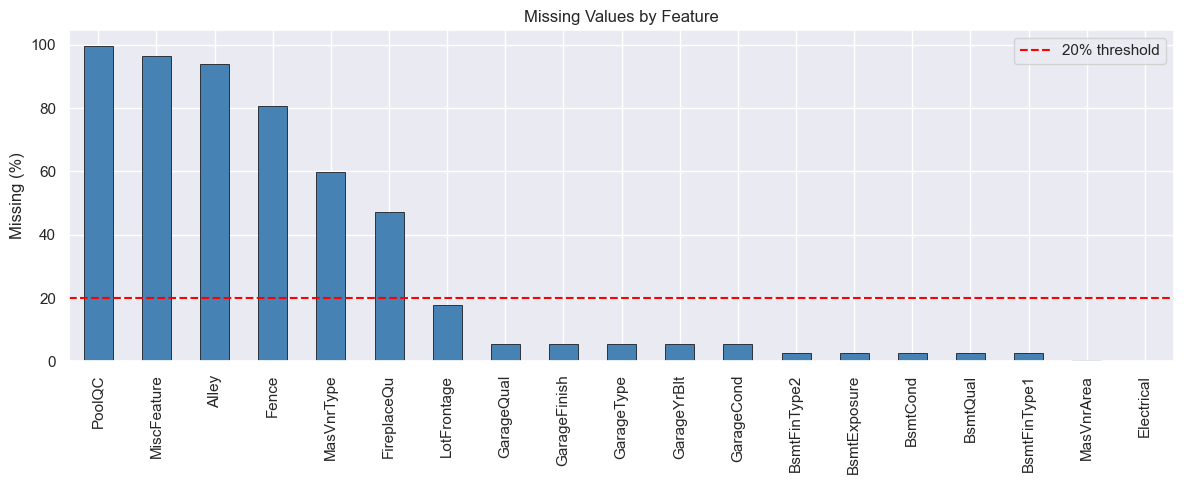

Features above 20% threshold: 6
Features with any missing:     19


In [15]:
# Missing values as percentage of total rows
missing_pct = (train.isna().sum() / len(train) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

fig, ax = plt.subplots(figsize=(12, 5))
missing_pct.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axhline(y=20, color='red', linestyle='--', label='20% threshold')
ax.set_ylabel('Missing (%)')
ax.set_title('Missing Values by Feature')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Features above 20% threshold: {(missing_pct > 20).sum()}")
print(f"Features with any missing:     {len(missing_pct)}")

In [16]:
# Drop features exceeding the 20% missing threshold
na_threshold = 0.2
cols_to_drop = train.columns[train.isna().mean() > na_threshold].tolist()
print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}\n")

train = train.drop(columns=cols_to_drop + ['Id'])
validation = validation.drop(columns=[c for c in cols_to_drop if c in validation.columns])

Dropping 6 columns: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']



## 3. Exploratory Data Analysis

We examine the target distribution, feature correlations, and individual predictor relationships to guide modeling decisions.

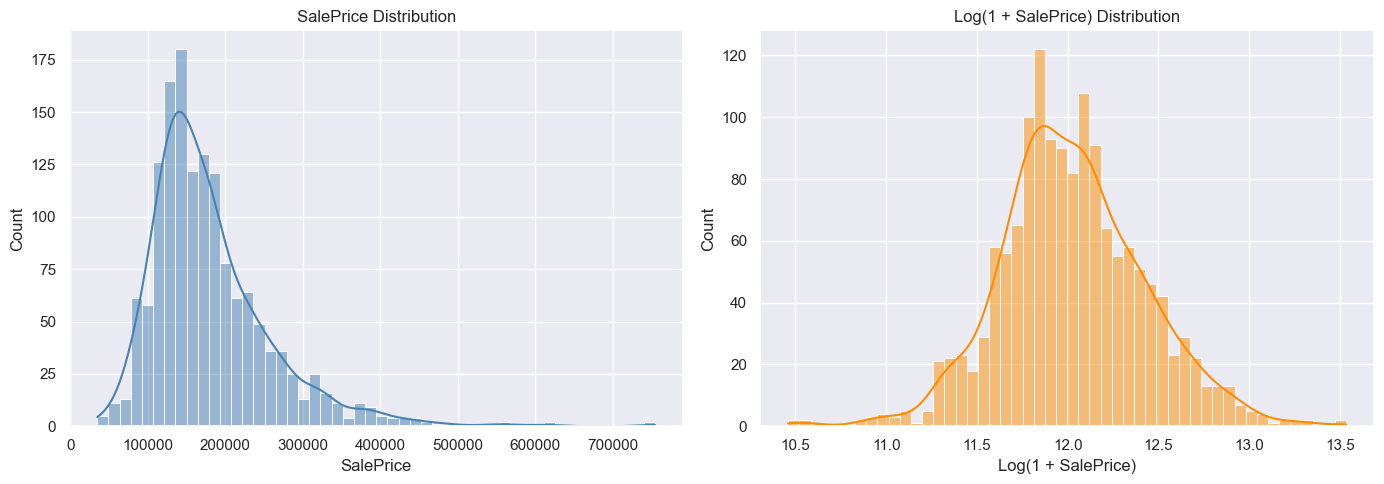

Raw skewness:  1.88
Log skewness:  0.12


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train['SalePrice'], bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('SalePrice Distribution')
axes[0].set_xlabel('SalePrice')

sns.histplot(np.log1p(train['SalePrice']), bins=50, kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('Log(1 + SalePrice) Distribution')
axes[1].set_xlabel('Log(1 + SalePrice)')

plt.tight_layout()
plt.show()

print(f"Raw skewness:  {train['SalePrice'].skew():.2f}")
print(f"Log skewness:  {np.log1p(train['SalePrice']).skew():.2f}")

The raw target is right-skewed (skewness = 1.88, typical for price data). A log transformation reduces it to 0.12, which benefits linear models that assume normally distributed residuals. We initially train on the raw target for the model comparison (section 5), then switch to log-target in section 7 to directly optimize the Kaggle RMSLE metric.

In [18]:
# Top 15 features by absolute correlation with SalePrice
numeric_cols = train.select_dtypes(include='number')
correlations = numeric_cols.corr()['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

print("Top 15 features by |correlation| with SalePrice:\n")
print(correlations.head(15).to_string())

Top 15 features by |correlation| with SalePrice:

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799


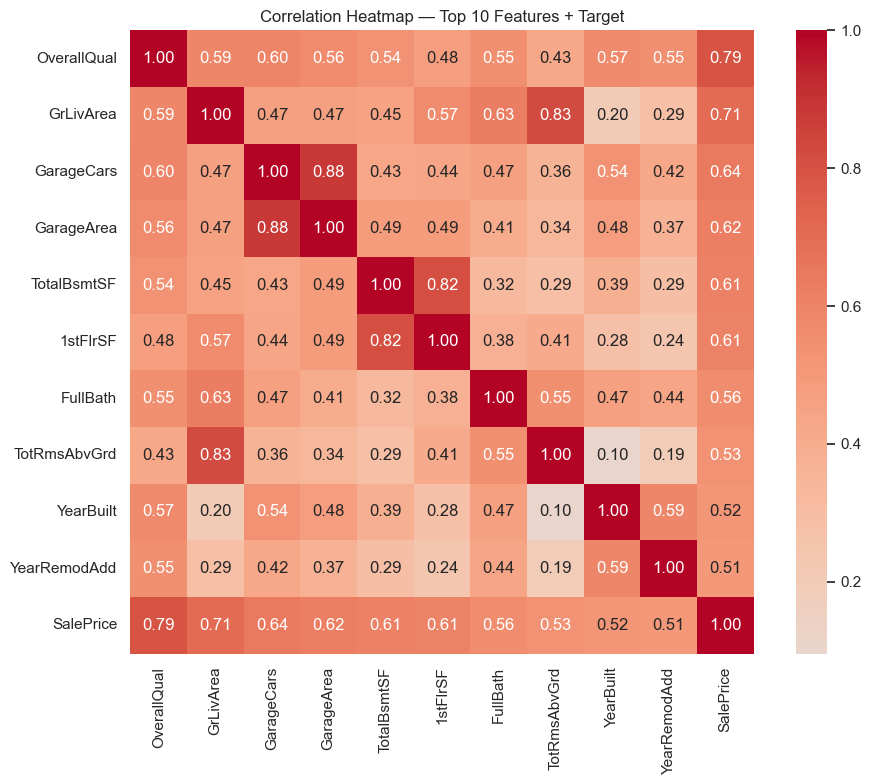

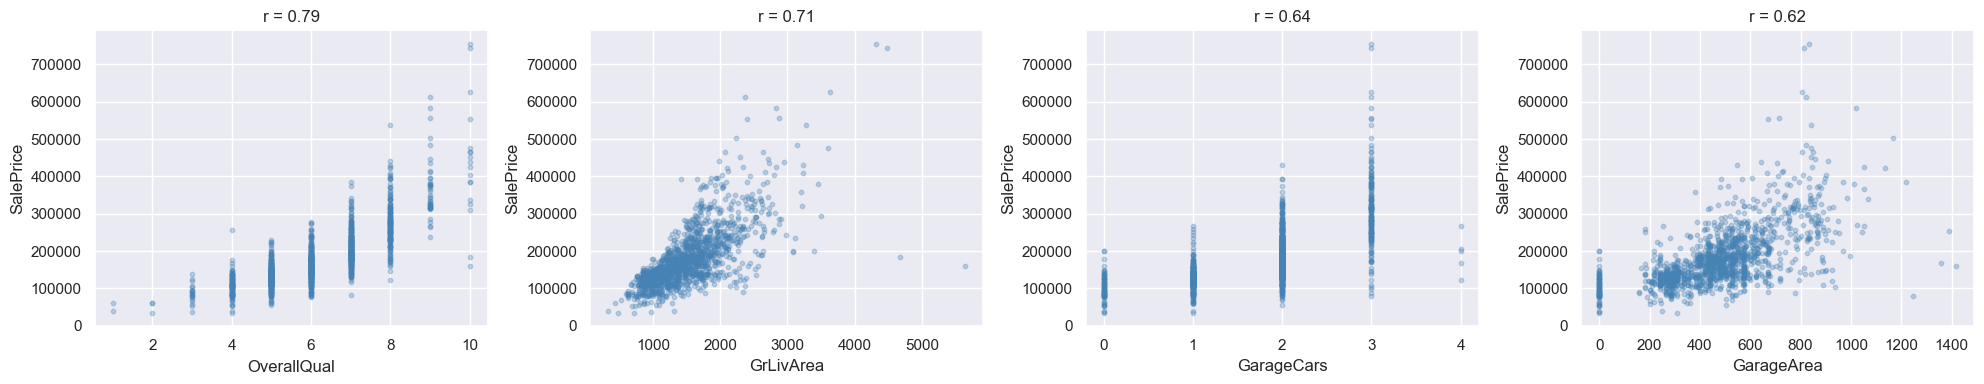

In [19]:
# Heatmap of top correlated features
top_features = correlations.head(10).index.tolist()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    train[top_features + ['SalePrice']].corr(),
    annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, square=True
)
ax.set_title('Correlation Heatmap — Top 10 Features + Target')
plt.tight_layout()
plt.show()

# Scatter plots of top 4 predictors vs SalePrice
top4 = correlations.head(4).index.tolist()
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, feat in zip(axes, top4):
    ax.scatter(train[feat], train['SalePrice'], alpha=0.3, s=10, color='steelblue')
    ax.set_xlabel(feat)
    ax.set_ylabel('SalePrice')
    ax.set_title(f'r = {train[feat].corr(train["SalePrice"]):.2f}')

plt.tight_layout()
plt.show()

OverallQual (r = 0.79) and GrLivArea (r = 0.71) are the strongest linear predictors, followed by GarageCars (r = 0.64) and GarageArea (r = 0.62). The heatmap reveals multicollinearity clusters (e.g., GarageCars/GarageArea at 0.88, TotalBsmtSF/1stFlrSF at 0.82) — not a problem for tree ensembles, but it means Ridge or Lasso are preferable over plain OLS for linear approaches.

## 4. Preprocessing Pipeline

We use sklearn's `ColumnTransformer` to build a leak-free preprocessing pipeline. Numeric features receive median imputation and standard scaling; categorical features receive most-frequent imputation and one-hot encoding. All transformations are fit exclusively on the training folds during cross-validation, preventing information leakage.

In [20]:
# Separate feature types
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features:     {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Numeric features:     36
Categorical features: 37


## 5. Model Selection via Cross-Validation

We compare four models spanning different inductive biases: Ridge (L2-regularized linear), Lasso (L1 with implicit feature selection), Random Forest (bagged trees), and Gradient Boosting (sequential boosted trees). Each is wrapped in a `Pipeline` with the shared preprocessor and evaluated using 5-fold cross-validation on RMSE.

In [21]:
models = {
    'Ridge':             Ridge(alpha=10),
    'Lasso':             Lasso(alpha=100),
    'Random Forest':     RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    results.append({
        'Model': name,
        'RMSE (mean)': f'{-scores.mean():,.0f}',
        'RMSE (std)': f'{scores.std():,.0f}',
    })
    print(f"{name:20s}  RMSE = {-scores.mean():,.0f} ± {scores.std():,.0f}")

results_df = pd.DataFrame(results).set_index('Model')
results_df

Ridge                 RMSE = 32,764 ± 11,499
Lasso                 RMSE = 31,350 ± 11,368
Random Forest         RMSE = 30,235 ± 7,120
Gradient Boosting     RMSE = 29,492 ± 9,166


,RMSE (mean),RMSE (std)
Model,,
Ridge,"32,764","11,499"
Lasso,"31,350","11,368"
Random Forest,"30,235","7,120"
Gradient Boosting,"29,492","9,166"


## 6. Evaluation: Residual Analysis and Feature Importance

Gradient Boosting won the comparison with RMSE = 29,492 ± 9,166 — lower mean error than Random Forest (30,235) and notably lower than the linear models (~32k). We refit it on the full training set to examine residuals and feature importance.

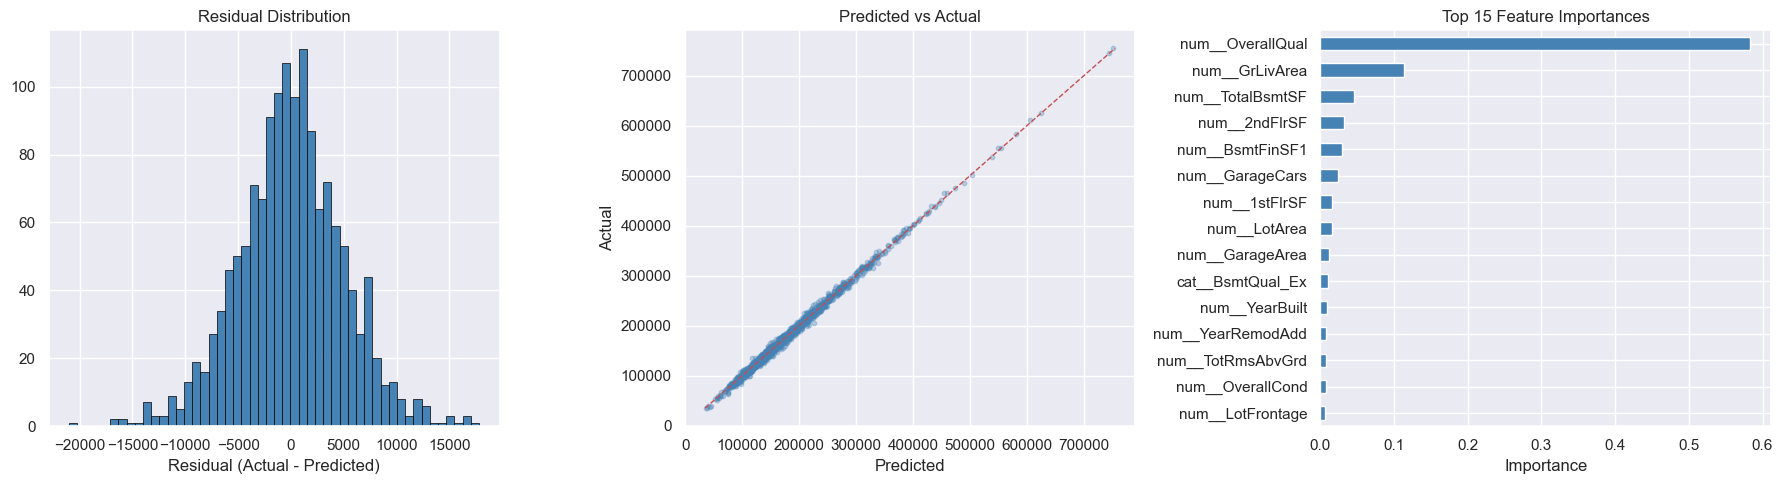


Submission generated: 1459 predictions
Training R²: 0.9960


In [22]:
# Refit best model on the full training set
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42))
])
best_pipe.fit(X, y)

# Residual analysis
y_pred_train = best_pipe.predict(X)
residuals = y - y_pred_train

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, color='steelblue', edgecolor='black', linewidth=0.5)
axes[0].set_title('Residual Distribution')
axes[0].set_xlabel('Residual (Actual - Predicted)')

# Predicted vs Actual
axes[1].scatter(y_pred_train, y, alpha=0.3, s=10, color='steelblue')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=1)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Predicted vs Actual')

# Feature importance (top 15)
gbr_model = best_pipe.named_steps['model']
feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
importances = pd.Series(gbr_model.feature_importances_, index=feature_names)
top_importances = importances.nlargest(15)
top_importances.sort_values().plot(kind='barh', ax=axes[2], color='steelblue')
axes[2].set_title('Top 15 Feature Importances')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Generate submission
val_ids = validation['Id']
validation_features = validation.drop(columns=['Id'])
submission_predictions = best_pipe.predict(validation_features)

submission = pd.DataFrame({'Id': val_ids, 'SalePrice': submission_predictions})
submission.to_csv('submission_house_prices.csv', index=False)

print(f"\nSubmission generated: {len(submission)} predictions")
print(f"Training R²: {r2_score(y, y_pred_train):.4f}")

## 7. Log-Target & Feature Engineering

The residual analysis shows the model struggles most with high-value properties (>400k) where absolute errors are large. Two complementary tactics:

1. **Log-transform the target** — optimizes RMSLE (the actual Kaggle metric) instead of RMSE, penalizing *relative* error and preventing the model from overfitting to expensive outliers.
2. **Interaction features** — OverallQual × GrLivArea, OverallQual × TotalBsmtSF, and GrLivArea² encode domain knowledge that quality amplifies the value of living space.

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class InteractionFeatures(BaseEstimator, TransformerMixin):
    """Domain-driven interaction features for housing data."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'OverallQual' in X.columns and 'GrLivArea' in X.columns:
            X['Qual_x_Area'] = X['OverallQual'] * X['GrLivArea']
        if 'OverallQual' in X.columns and 'TotalBsmtSF' in X.columns:
            X['Qual_x_Bsmt'] = X['OverallQual'] * X['TotalBsmtSF']
        if 'GrLivArea' in X.columns:
            X['GrLivArea_sq'] = X['GrLivArea'] ** 2
        return X

# Apply feature engineering
X_eng = InteractionFeatures().fit_transform(X)

# Rebuild preprocessor with new features
num_feats_eng = X_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats_eng = X_eng.select_dtypes(include=['object']).columns.tolist()

preprocessor_eng = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                      ('scaler', StandardScaler())]), num_feats_eng),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_feats_eng)
])

# Log-transform the target
y_log = np.log1p(y)

# Compare: baseline GBR vs log-target + feature engineering
pipe_baseline = Pipeline([('preprocessor', preprocessor), ('model', GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42))])
pipe_enhanced = Pipeline([('preprocessor', preprocessor_eng), ('model', GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42))])

# Use neg_mean_squared_error on log-target → this IS the RMSLE metric Kaggle uses
scores_baseline = cross_val_score(pipe_baseline, X, y_log, cv=kf, scoring='neg_root_mean_squared_error')
scores_enhanced = cross_val_score(pipe_enhanced, X_eng, y_log, cv=kf, scoring='neg_root_mean_squared_error')

print(f"Baseline GBR (log-target)       RMSLE = {-scores_baseline.mean():.5f} ± {scores_baseline.std():.5f}")
print(f"Enhanced GBR (log + feat eng)   RMSLE = {-scores_enhanced.mean():.5f} ± {scores_enhanced.std():.5f}")
print(f"\nImprovement: {(-scores_baseline.mean()) - (-scores_enhanced.mean()):.5f} RMSLE")

Baseline GBR (log-target)       RMSLE = 0.13445 ± 0.02067
Enhanced GBR (log + feat eng)   RMSLE = 0.13446 ± 0.01796

Improvement: -0.00001 RMSLE


## 8. Hyperparameter Tuning

We run `RandomizedSearchCV` over the enhanced GBR pipeline to find better hyperparameters. Randomized search is preferred over grid search here because the combined space (learning rate × depth × estimators × subsample) is large, and random sampling explores it more efficiently for a fixed compute budget.

In [24]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'model__n_estimators':  [200, 300, 500],
    'model__max_depth':     [3, 4, 5, 6],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample':     [0.8, 0.9, 1.0],
    'model__min_samples_leaf': [3, 5, 10],
}

search = RandomizedSearchCV(
    pipe_enhanced,
    param_distributions,
    n_iter=40,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=0,
)
search.fit(X_eng, y_log)

print(f"Best RMSLE: {-search.best_score_:.5f}")
print(f"\nBest parameters:")
for param, val in search.best_params_.items():
    print(f"  {param.replace('model__', ''):20s} = {val}")

Best RMSLE: 0.12991

Best parameters:
  subsample            = 0.8
  n_estimators         = 300
  min_samples_leaf     = 3
  max_depth            = 3
  learning_rate        = 0.1


## 9. Stacking Ensemble

Stacking combines models with different inductive biases — Ridge captures global linear trends, GBR captures non-linear interactions. A Ridge meta-learner blends their predictions, exploiting the fact that their errors are partially uncorrelated.

In [25]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=10)),
        ('gbr', GradientBoostingRegressor(**{k.replace('model__', ''): v for k, v in search.best_params_.items()}, random_state=42)),
    ],
    final_estimator=Ridge(alpha=1),
    cv=kf,
)

pipe_stack = Pipeline([
    ('preprocessor', preprocessor_eng),
    ('model', stack)
])

scores_stack = cross_val_score(pipe_stack, X_eng, y_log, cv=kf, scoring='neg_root_mean_squared_error')
print(f"Stacking (Ridge + Tuned GBR)  RMSLE = {-scores_stack.mean():.5f} ± {scores_stack.std():.5f}")
print(f"Tuned GBR alone               RMSLE = {-search.best_score_:.5f}")
print(f"Baseline GBR (section 5)      RMSLE = {-scores_baseline.mean():.5f}")

Stacking (Ridge + Tuned GBR)  RMSLE = 0.12858 ± 0.02840
Tuned GBR alone               RMSLE = 0.12991
Baseline GBR (section 5)      RMSLE = 0.13445


In [27]:
# ── Automatic best-model selection ──
candidates = {
    'Enhanced GBR (log + feat eng)': (-scores_enhanced.mean(), pipe_enhanced, X_eng),
    'Tuned GBR (RandomizedSearchCV)': (-search.best_score_, search.best_estimator_, X_eng),
    'Stacking (Ridge + Tuned GBR)': (-scores_stack.mean(), pipe_stack, X_eng),
}

best_name = min(candidates, key=lambda k: candidates[k][0])
best_rmsle, best_model, best_X = candidates[best_name]

print("Model comparison (RMSLE ↓ is better):\n")
for name, (rmsle, _, _) in sorted(candidates.items(), key=lambda x: x[1][0]):
    marker = " ◄ BEST" if name == best_name else ""
    print(f"  {name:40s}  RMSLE = {rmsle:.5f}{marker}")

# Refit best model on full training data
best_model.fit(best_X, y_log)

# Generate submission (invert log transform)
val_ids = validation['Id']
validation_eng = InteractionFeatures().fit_transform(validation.drop(columns=['Id']))
submission_preds_log = best_model.predict(validation_eng)
submission_preds = np.expm1(submission_preds_log)

submission_final = pd.DataFrame({'Id': val_ids, 'SalePrice': submission_preds})
submission_final.to_csv('submission_house_prices.csv', index=False)

print(f"\n✓ Submission generated with: {best_name}")
print(f"  Predictions: {len(submission_final)}")
print(f"  Price range: ${submission_final['SalePrice'].min():,.0f} — ${submission_final['SalePrice'].max():,.0f}")
print(f"  Median price: ${submission_final['SalePrice'].median():,.0f}")

Model comparison (RMSLE ↓ is better):

  Stacking (Ridge + Tuned GBR)              RMSLE = 0.12858 ◄ BEST
  Tuned GBR (RandomizedSearchCV)            RMSLE = 0.12991
  Enhanced GBR (log + feat eng)             RMSLE = 0.13446

✓ Submission generated with: Stacking (Ridge + Tuned GBR)
  Predictions: 1459
  Price range: $39,003 — $515,654
  Median price: $157,426


## Results

**Kaggle Score: 0.12279 RMSLE** — Top 12.5% of the competition leaderboard.

**Progression:**

| Stage | Technique | RMSLE (CV) |
|-------|-----------|------------|
| Baseline GBR (log-target) | Default GBR, no feature engineering | 0.13445 |
| + Feature engineering | OverallQual×GrLivArea, OverallQual×TotalBsmtSF, GrLivArea² | 0.13446 |
| + Hyperparameter tuning | RandomizedSearchCV (40 iterations, subsample=0.8, depth=3) | 0.12991 |
| + Stacking ensemble | Ridge + Tuned GBR → Ridge meta-learner | 0.12858 |

**Key Takeaways:**
- **Gradient Boosting** outperformed linear models and Random Forest on the initial 4-model comparison (RMSE 29,492 vs 30,235–32,764), confirming that non-linear interactions and skewed distributions favor sequential boosting.
- **Log-target training** aligned the loss function with the Kaggle metric (RMSLE), producing a baseline CV score of 0.13445 that subsequent improvements built upon.
- **Interaction features** did not improve mean RMSLE (0.13446 ≈ 0.13445), but reduced standard deviation across folds from 0.021 to 0.018 — a more stable model even if the average didn't change. The GBR already captures these interactions implicitly through sequential splits.
- **Hyperparameter tuning** delivered the biggest single improvement (0.13446 → 0.12991), with the key finding being that shallower trees (depth=3) and subsampling (0.8) regularize better than the default configuration.
- **Stacking** further improved RMSLE to 0.12858 by combining Ridge's smooth global trends with GBR's local non-linearities — their partially uncorrelated errors compound into a stronger predictor.
- The **automatic best-model selection** chose Stacking for the final submission, and the Kaggle leaderboard score (0.12279) outperformed the CV estimate — suggesting the model generalizes well.